# Personal Model

With this notebook we try a new personal model. The goal of this "personal" model, is to have a more hand-on work and try to adjust parameters manually. By transforming the Difficulty levels into numeric values, we can try to compute feature values and through them, compute a new score for each sentence.
This first notebook serves as a semi-baseline, where we do some minor feature adjustements and very little preprocessing.

### Installing and importing the necessary libraries and packages

In [ ]:
!pip install unidecode
!pip install textstat

     |████████████████████████████████| 245kB 5.4MB/s 
     |████████████████████████████████| 102kB 4.4MB/s 
     |████████████████████████████████| 1.9MB 9.3MB/s 


In [ ]:
!pip install wordstats
!pip install nltk
!pip install spacy download fr
!spacy download fr_core_news_sm

     |████████████████████████████████| 3.6MB 6.9MB/s 
  Created wheel for wordstats: filename=wordstats-1.0.7-cp37-none-any.whl size=3616377 sha256=6123a2db007fcb7921d41a44f41f1839d321a7e64d729d82222ca401e8133ea6
  Stored in directory: /root/.cache/pip/wheels/19/cd/63/4f1be9b37f67fd5f305b3c7ac88fc8afdb88638589cfa37184
  Created wheel for configobj: filename=configobj-5.0.6-cp37-none-any.whl size=34547 sha256=4244b03f27d6dbe647b222f27686fb7542cb5d22d9a9d531fc7f27122418fcbc
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built wordstats configobj
     |████████████████████████████████| 14.7MB 5.5MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-cp37-none-any.whl size=14727027 sha256=fabb9e4c38d4703662d573e2d073e3772eb8368e43fedaf993db8c5b3480e476
  Stored in directory: /tmp/pip-ephem-wheel-cache-y6rfay1j/wheels/46/1b/e6/29b020e3f9420a24c3f463343afe5136aaaf955dbc9e46dfc5
Successfully built fr-

In [ ]:
!python3 -m spacy download fr_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [ ]:
import fr_core_news_sm

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import spacy
import string
from wordstats import Word, common_words
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Loading the data (our own personal data with the sentences that we collected)

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/ahusejn1/TeamApple_Big_Scale_Analytics/main/Data/Data.csv")

In [ ]:
df.head(5)

,Text,Difficulty
0,Franck est français.,A1
1,Il est employé,A1
2,Il habite en Italie avec sa femme et ses enfants.,A1
3,Il travaille à Rome,A1
4,Il parle italien et anglais,A1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098 entries, 0 to 1097
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Text        1098 non-null   object
 1   Difficulty  1098 non-null   object
dtypes: object(2)
memory usage: 17.3+ KB


In [ ]:
df.Text = df.Text.astype('str')

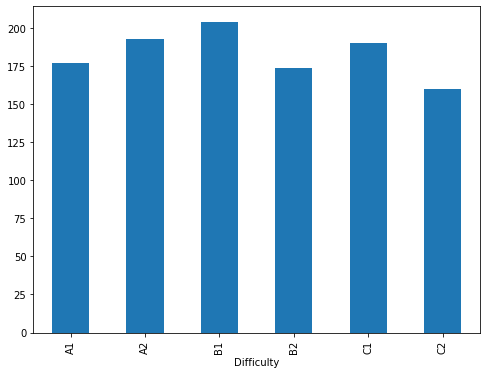

In [ ]:
fig = plt.figure(figsize=(8,6))
df.groupby('Difficulty').Text.count().plot.bar(ylim=0)
plt.show()

### Transform Categories into numeric values 

In [ ]:
df = df.replace(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'], [1,2,3,4,5,6])

In [ ]:
df.head(5)

,Text,Difficulty
0,Franck est français.,1
1,Il est employé,1
2,Il habite en Italie avec sa femme et ses enfants.,1
3,Il travaille à Rome,1
4,Il parle italien et anglais,1


In [ ]:
# pour plus tard
#df.Difficulty = pd.cut(df.Difficulty, bins=[0,1,2,3,4,5, 6], labels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])

In [ ]:
df.head(10)

,Text,Difficulty
0,Franck est français.,1
1,Il est employé,1
2,Il habite en Italie avec sa femme et ses enfants.,1
3,Il travaille à Rome,1
4,Il parle italien et anglais,1
5,Sa femme s’appelle Véronique,1
6,Elle a 38 ans,1
7,Elle ne travaille pas,1
8,Franck et Véronique aiment le théâtre et la danse,1
9,Ils vont souvent à l’opéra,1


## Feature augmentation
### Separate the words, in order to get the difficulty per word

In [ ]:
df["Word"] = ""

In [ ]:
sp = fr_core_news_sm.load()
len = df.shape[0]
ligne = 0
while ligne<len:
  text = str(df["Text"].iloc[ligne])
  theDoc = sp(text)
  token_list = []
  new_List = []
  for w in theDoc:
    token_list.append(w.text)
    if (w.pos_ == "PROPN") or (w.pos_ == "NUM"):
      token_list.remove(w.text)
  df["Word"].iloc[ligne] = token_list
  ligne += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df.head(15)

,Text,Difficulty,Word
0,Franck est français.,1,"[est, français, .]"
1,Il est employé,1,"[Il, est, employé]"
2,Il habite en Italie avec sa femme et ses enfants.,1,"[Il, habite, en, avec, sa, femme, et, ses, enf..."
3,Il travaille à Rome,1,"[Il, travaille, à]"
4,Il parle italien et anglais,1,"[Il, parle, italien, et, anglais]"
5,Sa femme s’appelle Véronique,1,"[Sa, femme, s’, appelle, Véronique]"
6,Elle a 38 ans,1,"[Elle, a, ans]"
7,Elle ne travaille pas,1,"[Elle, ne, travaille, pas]"
8,Franck et Véronique aiment le théâtre et la danse,1,"[et, aiment, le, théâtre, et, la, danse]"
9,Ils vont souvent à l’opéra,1,"[Ils, vont, souvent, à, opéra]"


In [ ]:
df["WordDifficulty"] = ""
df["AvgWordDiffic"] = ""

In [ ]:
df.head(10)

,Text,Difficulty,Word,WordDifficulty,AvgWordDiffic
0,Franck est français.,1,"[est, français, .]",,
1,Il est employé,1,"[Il, est, employé]",,
2,Il habite en Italie avec sa femme et ses enfants.,1,"[Il, habite, en, avec, sa, femme, et, ses, enf...",,
3,Il travaille à Rome,1,"[Il, travaille, à]",,
4,Il parle italien et anglais,1,"[Il, parle, italien, et, anglais]",,
5,Sa femme s’appelle Véronique,1,"[Sa, femme, s’, appelle, Véronique]",,
6,Elle a 38 ans,1,"[Elle, a, ans]",,
7,Elle ne travaille pas,1,"[Elle, ne, travaille, pas]",,
8,Franck et Véronique aiment le théâtre et la danse,1,"[et, aiment, le, théâtre, et, la, danse]",,
9,Ils vont souvent à l’opéra,1,"[Ils, vont, souvent, à, opéra]",,


In [ ]:
line = 0 
len = df.shape[0]
while line<len:
  newList = []
  for w in df.Word.iloc[line]:
    newList.append(Word.stats(w, "fr").difficulty)
  df.WordDifficulty.iloc[line] = newList
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
# Get the average word difficulty
line = 0 
len = df.shape[0]
while line<len:
  total = 0
  nb = 0
  for i in df.WordDifficulty.iloc[line]:
    total += i
    nb += 1
    df.AvgWordDiffic.iloc[line] = total/nb 
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
punct = string.punctuation

In [ ]:
line = 0 
len = df.shape[0]
while line<len:
  diffic = df.Word.iloc[line]
  for i in diffic:
    if (i in punct):
      diffic.remove(i)
  line += 1

In [ ]:
df.tail(10)

,Text,Difficulty,Word,WordDifficulty,AvgWordDiffic
1088,D’autres auteurs ont exploité ce terrain comme...,6,"[D’, autres, auteurs, ont, exploité, ce, terra...","[1, 0.0, 0.18, 0.0, 1, 0.0, 0.02, 0.0, 0.14, 0...",0.248571
1089,Mais il peut aussi se produire sur des informa...,6,"[Mais, il, peut, aussi, se, produire, sur, des...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.07, 0.0, 0.0, 0.02...",0.160882
1090,Une mémoire lexicale qui enregistre la carross...,6,"[Une, mémoire, lexicale, qui, enregistre, la, ...","[0.0, 0.02, 1, 0.0, 0.14, 0.0, 1, 0.0, 0.01, 1...",0.288333
1091,Le « rebâchage » envoie les données dans la pr...,6,"[Le, «, rebâchage, envoie, les, données, dans,...","[0.0, 1, 1, 0.01, 0.0, 0.03, 0.0, 0.0, 0.0, 0....",0.320444
1092,"Ainsi, un enfant qui a appris une leçon très s...",6,"[Ainsi, un, enfant, qui, a, appris, une, leçon...","[0.0, 1, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.03, ...",0.122609
1093,Si la connaissance est convoquée une troisième...,6,"[Si, la, connaissance, est, convoquée, une, tr...","[0.0, 0.0, 0.03, 0.0, 1, 0.0, 0.03, 0.0, 1, 0....",0.199722
1094,« Parce que les révisions aident à faire retro...,6,"[«, Parce, que, les, révisions, aident, à, fai...","[1, 0.0, 0.0, 0.0, 1, 0.15, 0.0, 0.0, 0.01, 0....",0.27913
1095,Un enfant peut avoir parfois l’impression d’av...,6,"[Un, enfant, peut, avoir, parfois, l’, impress...","[0.0, 0.0, 0.0, 0.0, 0.01, 1, 0.01, 1, 0.0, 0....",0.234444
1096,Un simple indice donné durant les vacances va ...,6,"[Un, simple, indice, donné, durant, les, vacan...","[0.0, 0.01, 0.06, 0.0, 0.02, 0.0, 0.02, 0.0, 0...",0.0127778
1097,"Revue une fois, elle sera cette fois plus faci...",5,"[Revue, une, fois, elle, sera, cette, fois, pl...","[0.09, 0.0, 0.0, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",0.260833


### Get the word frequency score 

In [ ]:
df["WordFrequency"] = ""
line = 0
while line<len:
  new_List = []
  for w in df.Word.iloc[line]:
    new_List.append(Word.stats(w, "fr").frequency)
  df.WordFrequency.iloc[line] = new_List
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df.head()

,Text,Difficulty,Word,WordDifficulty,AvgWordDiffic,WordFrequency
0,Franck est français.,1,"[est, français]","[0.0, 0.03, 1]",0.343333,"[15.6, 9.38]"
1,Il est employé,1,"[Il, est, employé]","[0.0, 0.0, 0.06]",0.02,"[15.06, 15.6, 8.48]"
2,Il habite en Italie avec sa femme et ses enfants.,1,"[Il, habite, en, avec, sa, femme, et, ses, enf...","[0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1]",0.103,"[15.06, 9.23, 14.74, 13.89, 12.77, 12.22, 15.0..."
3,Il travaille à Rome,1,"[Il, travaille, à]","[0.0, 0.01, 0.0]",0.00333333,"[15.06, 10.63, 15.08]"
4,Il parle italien et anglais,1,"[Il, parle, italien, et, anglais]","[0.0, 0.0, 0.07, 0.0, 0.02]",0.018,"[15.06, 11.55, 8.31, 15.08, 9.74]"


In [ ]:
# Get the average word frequency per sentence
df["AvgFreq"] = ""
line = 0
while line<len:
  tot = 0
  nb = 0
  for i in df.WordFrequency.iloc[line]:
    tot += i
    nb += 1
    df.AvgFreq.iloc[line] = tot/nb
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df.head()

,Text,Difficulty,Word,WordDifficulty,AvgWordDiffic,WordFrequency,AvgFreq
0,Franck est français.,1,"[est, français]","[0.0, 0.03, 1]",0.343333,"[15.6, 9.38]",12.49
1,Il est employé,1,"[Il, est, employé]","[0.0, 0.0, 0.06]",0.02,"[15.06, 15.6, 8.48]",13.0467
2,Il habite en Italie avec sa femme et ses enfants.,1,"[Il, habite, en, avec, sa, femme, et, ses, enf...","[0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1]",0.103,"[15.06, 9.23, 14.74, 13.89, 12.77, 12.22, 15.0...",12.9789
3,Il travaille à Rome,1,"[Il, travaille, à]","[0.0, 0.01, 0.0]",0.00333333,"[15.06, 10.63, 15.08]",13.59
4,Il parle italien et anglais,1,"[Il, parle, italien, et, anglais]","[0.0, 0.0, 0.07, 0.0, 0.02]",0.018,"[15.06, 11.55, 8.31, 15.08, 9.74]",11.948


### Adding the cognates

In [ ]:
cognates = pd.read_csv("https://raw.githubusercontent.com/ahusejn1/TeamApple_Big_Scale_Analytics/main/Data/cognates.csv")
cognates.head(10)

,Cognates
0,abandon
1,abbé
2,abdomen
3,abdominal
4,aberration
5,abolition
6,abominable
7,abondance
8,abondant
9,absence


In [ ]:
line = 0
len = cognates.shape[0]
cog_list = []
while line<len:
  text = str(cognates.Cognates.iloc[line])
  my_doc = sp(text)
  for i in my_doc:
    cog_list.append(i.text)
  line += 1

In [ ]:
df["Cognates"] = ""
df["cog"] = ""
line = 0
len = cognates.shape[0]
while line<len:
  list_cog = []
  num_cog = []
  for i in df.Word.iloc[line]:
    if i in cog_list:
      list_cog.append(i)
      df.Cognates.iloc[line] = list_cog
    if i in cog_list:
      num_cog.append(1)
      df.cog.iloc[line] = num_cog
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df.head(10)

,Text,Difficulty,Word,WordDifficulty,AvgWordDiffic,WordFrequency,AvgFreq,Cognates,cog
0,Franck est français.,1,"[est, français]","[0.0, 0.03, 1]",0.343333,"[15.6, 9.38]",12.49,[français],[1]
1,Il est employé,1,"[Il, est, employé]","[0.0, 0.0, 0.06]",0.02,"[15.06, 15.6, 8.48]",13.0467,[employé],[1]
2,Il habite en Italie avec sa femme et ses enfants.,1,"[Il, habite, en, avec, sa, femme, et, ses, enf...","[0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1]",0.103,"[15.06, 9.23, 14.74, 13.89, 12.77, 12.22, 15.0...",12.9789,,
3,Il travaille à Rome,1,"[Il, travaille, à]","[0.0, 0.01, 0.0]",0.00333333,"[15.06, 10.63, 15.08]",13.59,,
4,Il parle italien et anglais,1,"[Il, parle, italien, et, anglais]","[0.0, 0.0, 0.07, 0.0, 0.02]",0.018,"[15.06, 11.55, 8.31, 15.08, 9.74]",11.948,[anglais],[1]
5,Sa femme s’appelle Véronique,1,"[Sa, femme, s’, appelle, Véronique]","[0.0, 0.0, 1, 0.0, 1]",0.4,"[12.77, 12.22, 0, 11.61, 0]",7.32,,
6,Elle a 38 ans,1,"[Elle, a, ans]","[0.0, 0.0, 0.0]",0,"[14.06, 14.96, 12.18]",13.7333,,
7,Elle ne travaille pas,1,"[Elle, ne, travaille, pas]","[0.0, 0.0, 0.01, 0.0]",0.0025,"[14.06, 14.87, 10.63, 15.43]",13.7475,,
8,Franck et Véronique aiment le théâtre et la danse,1,"[et, aiment, le, théâtre, et, la, danse]","[0.0, 0.02, 0.0, 0.04, 0.0, 0.0, 0.02]",0.0114286,"[15.08, 9.52, 15.33, 9.05, 15.08, 15.23, 9.78]",12.7243,"[théâtre, danse]","[1, 1]"
9,Ils vont souvent à l’opéra,1,"[Ils, vont, souvent, à, opéra]","[0.0, 0.0, 0.01, 0.0, 0.09]",0.02,"[13.6, 11.23, 10.38, 15.08, 8.05]",11.668,,


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098 entries, 0 to 1097
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Text            1098 non-null   object
 1   Difficulty      1098 non-null   int64 
 2   Word            1098 non-null   object
 3   WordDifficulty  1098 non-null   object
 4   AvgWordDiffic   1098 non-null   object
 5   WordFrequency   1098 non-null   object
 6   AvgFreq         1098 non-null   object
 7   Cognates        1098 non-null   object
 8   cog             1098 non-null   object
dtypes: int64(1), object(8)
memory usage: 77.3+ KB


In [ ]:
df.AvgWordDiffic = df.AvgWordDiffic.astype(float)
df.AvgFreq = df.AvgFreq.astype(float)

In [ ]:
df.head()

,Text,Difficulty,Word,WordDifficulty,AvgWordDiffic,WordFrequency,AvgFreq,Cognates,cog
0,Franck est français.,1,"[est, français]","[0.0, 0.03, 1]",0.343333,"[15.6, 9.38]",12.490000,[français],[1]
1,Il est employé,1,"[Il, est, employé]","[0.0, 0.0, 0.06]",0.020000,"[15.06, 15.6, 8.48]",13.046667,[employé],[1]
2,Il habite en Italie avec sa femme et ses enfants.,1,"[Il, habite, en, avec, sa, femme, et, ses, enf...","[0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1]",0.103000,"[15.06, 9.23, 14.74, 13.89, 12.77, 12.22, 15.0...",12.978889,,
3,Il travaille à Rome,1,"[Il, travaille, à]","[0.0, 0.01, 0.0]",0.003333,"[15.06, 10.63, 15.08]",13.590000,,
4,Il parle italien et anglais,1,"[Il, parle, italien, et, anglais]","[0.0, 0.0, 0.07, 0.0, 0.02]",0.018000,"[15.06, 11.55, 8.31, 15.08, 9.74]",11.948000,[anglais],[1]


### Create a True or False column for the cognates

In [ ]:
df['hasCog'] = np.where(df['cog']!= '', True, False)

In [ ]:
# Transform True or False into numeric values
df.hasCog = df.hasCog.replace([True, False], [1,0])

In [ ]:
df.head()

,Text,Difficulty,Word,WordDifficulty,AvgWordDiffic,WordFrequency,AvgFreq,Cognates,cog,hasCog
0,Franck est français.,1,"[est, français]","[0.0, 0.03, 1]",0.343333,"[15.6, 9.38]",12.490000,[français],[1],1
1,Il est employé,1,"[Il, est, employé]","[0.0, 0.0, 0.06]",0.020000,"[15.06, 15.6, 8.48]",13.046667,[employé],[1],1
2,Il habite en Italie avec sa femme et ses enfants.,1,"[Il, habite, en, avec, sa, femme, et, ses, enf...","[0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1]",0.103000,"[15.06, 9.23, 14.74, 13.89, 12.77, 12.22, 15.0...",12.978889,,,0
3,Il travaille à Rome,1,"[Il, travaille, à]","[0.0, 0.01, 0.0]",0.003333,"[15.06, 10.63, 15.08]",13.590000,,,0
4,Il parle italien et anglais,1,"[Il, parle, italien, et, anglais]","[0.0, 0.0, 0.07, 0.0, 0.02]",0.018000,"[15.06, 11.55, 8.31, 15.08, 9.74]",11.948000,[anglais],[1],1


In [ ]:
df.dtypes

Text               object
Difficulty          int64
Word               object
WordDifficulty     object
AvgWordDiffic     float64
WordFrequency      object
AvgFreq           float64
Cognates           object
cog                object
hasCog              int64
dtype: object

### Creae a new dataset with only the necessary columns

In [ ]:
df_1 = df[['Text','AvgFreq','AvgWordDiffic', 'hasCog']].copy()

In [ ]:
df_1.head()

,Text,AvgFreq,AvgWordDiffic,hasCog
0,Franck est français.,12.490000,0.343333,1
1,Il est employé,13.046667,0.020000,1
2,Il habite en Italie avec sa femme et ses enfants.,12.978889,0.103000,0
3,Il travaille à Rome,13.590000,0.003333,0
4,Il parle italien et anglais,11.948000,0.018000,1


Standardize some feature values

In [ ]:
normalized = df_1.copy()
cols_to_norm = ['AvgWordDiffic']
normalized[cols_to_norm]=(df_1[cols_to_norm]-df_1[cols_to_norm].min())/(df_1[cols_to_norm].max()-df_1[cols_to_norm].min())

In [ ]:
cols_to_norm = ['AvgFreq']
normalized[cols_to_norm]=(df_1[cols_to_norm]-df_1[cols_to_norm].min())/(df_1[cols_to_norm].max()-df_1[cols_to_norm].min())

In [ ]:
normalized.head()

,Text,AvgFreq,AvgWordDiffic,hasCog
0,Franck est français.,0.791230,0.024793,0
1,Il est employé,0.845877,0.033058,0
2,Il habite en Italie avec sa femme et ses enfants.,0.839223,0.005510,1
3,Il travaille à Rome,0.899215,0.005510,1
4,Il parle italien et anglais,0.738024,0.029752,0


Reverse some values for computation purposes

In [ ]:
def get_negative(x):
	return 1 - x

In [ ]:
normalized["hasCog"] = normalized["hasCog"].apply(get_negative)

In [ ]:
normalized["AvgFreq"] = normalized["AvgFreq"].apply(get_negative)

In [ ]:
normalized.dtypes

Text              object
AvgFreq          float64
AvgWordDiffic    float64
hasCog             int64
dtype: object

Create new column with the new computed numeric Scores

In [ ]:
normalized['Score'] = normalized['AvgFreq'] + normalized['AvgWordDiffic'] + normalized['hasCog']

In [ ]:
normalized.head()

,Text,AvgFreq,AvgWordDiffic,hasCog,Score
0,Franck est français.,0.208770,0.535697,0,0.744467
1,Il est employé,0.154123,0.031206,0,0.185329
2,Il habite en Italie avec sa femme et ses enfants.,0.160777,0.160709,1,1.321486
3,Il travaille à Rome,0.100785,0.005201,1,1.105986
4,Il parle italien et anglais,0.261976,0.028085,0,0.290062


In [ ]:
# Standardize the Score column
cols_to_norm = ['Score']
normalized[cols_to_norm]=(normalized[cols_to_norm]-normalized[cols_to_norm].min())/(normalized[cols_to_norm].max()-normalized[cols_to_norm].min())

In [ ]:
normalized.head()

,Text,AvgFreq,AvgWordDiffic,hasCog,Score
0,Franck est français.,0.208770,0.535697,0,0.221221
1,Il est employé,0.154123,0.031206,0,0.019811
2,Il habite en Italie avec sa femme et ses enfants.,0.160777,0.160709,1,0.429072
3,Il travaille à Rome,0.100785,0.005201,1,0.351446
4,Il parle italien et anglais,0.261976,0.028085,0,0.057537


Transform back to Categorical values

In [ ]:
normalized.Score = pd.cut(normalized.Score, bins=[0,0.16,0.26,0.41,0.51,0.6,1], labels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])

In [ ]:
normalized.Score.value_counts()

C2    212
A2    187
C1    184
B1    180
A1    172
B2    162
Name: Score, dtype: int64

In [ ]:
# Fill NaN values
normalized['Score'].isnull().sum()

1

In [ ]:
bbb = normalized[normalized['Score'].isna()]
bbb

,Text,AvgFreq,AvgWordDiffic,hasCog,Score
675,Les Américains ont bien de la chance,0.123644,0.006687,0,NaN


In [ ]:
normalized['Score'] = normalized['Score'].fillna('B2')

## Train and Test split & Model testing

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels

In [ ]:
def evaluate(true, pred):
    precision = precision_score(true, pred, average='macro')
    recall = recall_score(true, pred, average='macro')
    f1 = f1_score(true, pred, average='macro')
    print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

In [ ]:
X = normalized[['AvgFreq','AvgWordDiffic','hasCog']]
y = normalized.Score

In [ ]:
X.isnull().sum()

AvgFreq          0
AvgWordDiffic    0
hasCog           0
dtype: int64

In [ ]:
# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [ ]:
X_train = np.array(X_train)  
X_test = np.array(X_test)  

Classifier model

In [ ]:
RF = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=72)
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=72, verbose=0,
                       warm_start=False)

In [ ]:
pred = RF.predict(X_test)

In [ ]:
evaluate(y_test, pred)

CONFUSION MATRIX:
[[32  1  0  0  0  0]
 [ 4 33  1  0  0  0]
 [ 0  4 23  8  0  0]
 [ 0  0  2 20  8  0]
 [ 0  0  0  0 37  4]
 [ 0  0  0  0  0 43]]
ACCURACY SCORE:
0.8545
CLASSIFICATION REPORT:
	Precision: 0.8489
	Recall: 0.8441
	F1_Score: 0.8426


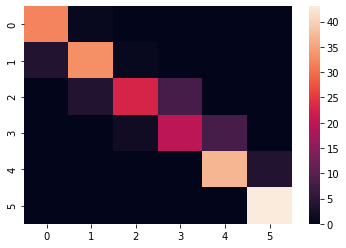

In [ ]:
sns.heatmap(confusion_matrix(y_test, pred))

In [ ]:
LR = LogisticRegression(solver='lbfgs')
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

In [ ]:
evaluate(y_test, y_pred)

CONFUSION MATRIX:
[[33  0  0  0  0  0]
 [ 2 36  0  0  0  0]
 [ 0 26  1  8  0  0]
 [ 0  0  1 17 11  1]
 [ 0  0  0  0 35  6]
 [ 0  0  0  0  0 43]]
ACCURACY SCORE:
0.7500
CLASSIFICATION REPORT:
	Precision: 0.7207
	Recall: 0.7327
	F1_Score: 0.6820


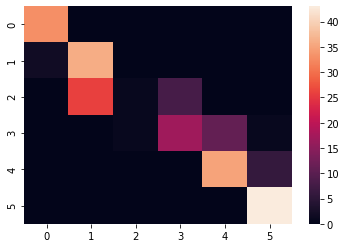

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred))